#### Inspection of different features and their impact on the condition

This script includes several analysis with different features to find out if their impact on the `condition of the bridge` differs between the two states `Thüringen` and `Sachsen-Anhalt`. We looked at: 
- `length`
- `motorway/federal highway`
- `GDP 2022`
- `prestressed concrete` (Spannbeton)

Furthermore, we produced a correlation heatmap including all numerical features. 

Finally, a random forest was performed, one for `Thüringen` and another one for `Sachsen-Anhalt`. 

In [ ]:
# load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import shap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [4]:
# read data
data = pd.read_csv('../../data/final_bridge_statistic_germany.csv', sep=';')

# split into bridges from Thüringen and Sachsen-Anhalt
data_thueringen = data[data['Bundeslandname'] == 'Thueringen']
data_sachsen_anhalt = data[data['Bundeslandname'] == 'Sachsen-Anhalt']

##### Length vs. Condition

`Thüringen` has the shortest and longest bridge. 

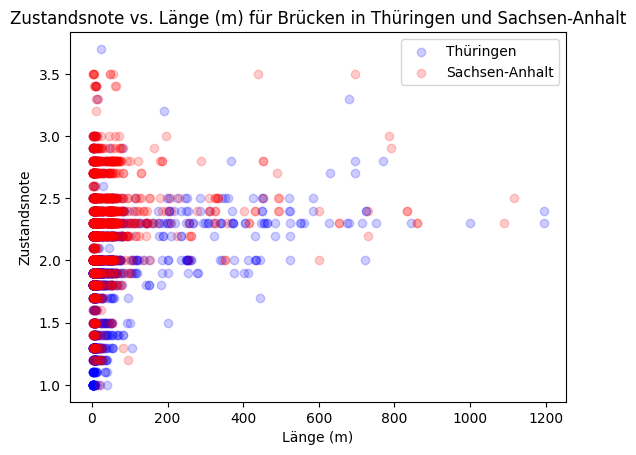

Thüringen - Kürzeste Brücke: 2.05 m, Längste Brücke: 1194.4 m
Sachsen-Anhalt - Kürzeste Brücke: 2.15 m, Längste Brücke: 1115.0 m


In [5]:
# print Zustandsnote ~ Länge (m)
plt.scatter(data_thueringen['Länge (m)'], data_thueringen['Zustandsnote'], color='blue', label='Thüringen', alpha=0.2)
plt.scatter(data_sachsen_anhalt['Länge (m)'], data_sachsen_anhalt['Zustandsnote'], color='red', label='Sachsen-Anhalt', alpha=0.2)
plt.xlabel('Länge (m)')
plt.ylabel('Zustandsnote')
plt.title('Zustandsnote vs. Länge (m) für Brücken in Thüringen und Sachsen-Anhalt')
plt.legend()
plt.show()

# print which state has the smallest and longest bridge
min_length_thueringen = data_thueringen['Länge (m)'].min()
max_length_thueringen = data_thueringen['Länge (m)'].max()
min_length_sachsen_anhalt = data_sachsen_anhalt['Länge (m)'].min()
max_length_sachsen_anhalt = data_sachsen_anhalt['Länge (m)'].max()
print(f"Thüringen - Kürzeste Brücke: {min_length_thueringen} m, Längste Brücke: {max_length_thueringen} m")
print(f"Sachsen-Anhalt - Kürzeste Brücke: {min_length_sachsen_anhalt} m, Längste Brücke: {max_length_sachsen_anhalt} m")

##### Motorway/Federal Highway vs. Condition

There is no big difference between Motorway (A) and Federal Highway (B) with respect to the condition within one state. The average condition is just shifted when comparing `Thüringen` and `Sachsen-Anhalt` independent of the type of the road. 

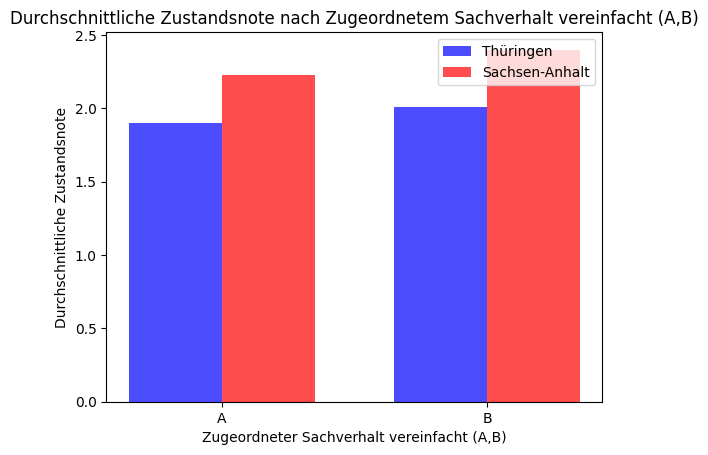

In [6]:
# print Zustandsnote ~ Zugeordneter Sachverhalt vereinfacht (A,B) -> normales Balkendiagramm mit zwei Balken pro Kategorie
data_thueringen_grouped = data_thueringen.groupby('Zugeordneter Sachverhalt vereinfacht')['Zustandsnote'].mean()
data_sachsen_anhalt_grouped = data_sachsen_anhalt.groupby('Zugeordneter Sachverhalt vereinfacht')['Zustandsnote'].mean()
labels = data_thueringen_grouped.index.tolist()
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars   
fig, ax = plt.subplots()
bars1 = ax.bar(x - width/2, data_thueringen_grouped, width, label='Thüringen', color='blue', alpha=0.7)
bars2 = ax.bar(x + width/2, data_sachsen_anhalt_grouped, width, label='Sachsen-Anhalt', color='red', alpha=0.7)
ax.set_xlabel('Zugeordneter Sachverhalt vereinfacht (A,B)')
ax.set_ylabel('Durchschnittliche Zustandsnote')
ax.set_title('Durchschnittliche Zustandsnote nach Zugeordnetem Sachverhalt vereinfacht (A,B)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.show()

##### GDP vs. Condition

There is no clear correlation between GDP and the condition of the bridges within those district. Higher GDP does not lead to a lower condition. 

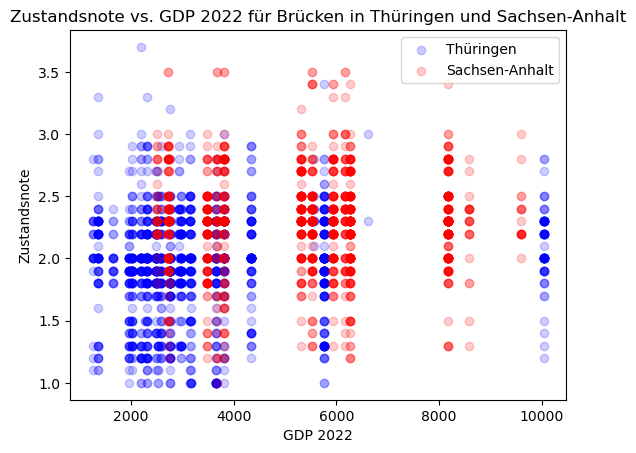

In [26]:
# plot Zustandsnote ~ GDP 2022
plt.scatter(data_thueringen['GDP 2022'], data_thueringen['Zustandsnote'], color='blue', label='Thüringen', alpha=0.2)
plt.scatter(data_sachsen_anhalt['GDP 2022'], data_sachsen_anhalt['Zustandsnote'], color='red', label='Sachsen-Anhalt', alpha=0.2)
plt.xlabel('GDP 2022')
plt.ylabel('Zustandsnote')
plt.title('Zustandsnote vs. GDP 2022 für Brücken in Thüringen und Sachsen-Anhalt')
plt.legend()
plt.show()

##### Material pestressed concrete vs. Condition

The amount of bridged built with pestressed concrete (Spannbeton) in both states is rather similar (520 vs. 578). However, the average condition is shifted when looking at `Thüringen` and `Sachsen-Anhalt` and all pestressed concrete bridges. The same accounts for all bridges not build from pestressed concrete. 

In [8]:
# analysis of bridges with Baustoffklasse Spannbeton
data_thueringen_spannbeton = data_thueringen[data_thueringen['Baustoffklasse'] == 'Spannbeton']
data_sachsen_anhalt_spannbeton = data_sachsen_anhalt[data_sachsen_anhalt['Baustoffklasse'] == 'Spannbeton']

# print amount of bridges + percentage
print(f"Number of bridges with Baustoffklasse (building materials class) Spannbeton (prestressed concrete) in Thüringen: {len(data_thueringen_spannbeton)} ({len(data_thueringen_spannbeton) / len(data_thueringen) * 100:.2f}%)")
print(f"Number of bridges with Baustoffklasse (building materials class) Spannbeton (prestressed concrete) in Sachsen-Anhalt: {len(data_sachsen_anhalt_spannbeton)} ({len(data_sachsen_anhalt_spannbeton) / len(data_sachsen_anhalt) * 100:.2f}%)")

# print average Zustandsnote for Spannbeton bridges
avg_zustandsnote_thueringen_spannbeton = data_thueringen_spannbeton['Zustandsnote'].mean()
avg_zustandsnote_sachsen_anhalt_spannbeton = data_sachsen_anhalt_spannbeton['Zustandsnote'].mean()
print(f"\n Average Zustandsnote (condition score) for Spannbeton (prestressed concrete) bridges in Thüringen: {avg_zustandsnote_thueringen_spannbeton:.2f}")
print(f"Average Zustandsnote (condition score) for Spannbeton (prestressed concrete) bridges in Sachsen-Anhalt: {avg_zustandsnote_sachsen_anhalt_spannbeton:.2f}")

# print average Zustandsnote for non-Spannbeton bridges
data_thueringen_non_spannbeton = data_thueringen[data_thueringen['Baustoffklasse'] != 'Spannbeton']
data_sachsen_anhalt_non_spannbeton = data_sachsen_anhalt[data_sachsen_anhalt['Baustoffklasse'] != 'Spannbeton']
avg_zustandsnote_thueringen_non_spannbeton = data_thueringen_non_spannbeton['Zustandsnote'].mean()  
avg_zustandsnote_sachsen_anhalt_non_spannbeton = data_sachsen_anhalt_non_spannbeton['Zustandsnote'].mean()
print(f"\nAverage Zustandsnote (condition score) for non-Spannbeton (non-prestressed concrete) bridges in Thüringen: {avg_zustandsnote_thueringen_non_spannbeton:.2f}")
print(f"Average Zustandsnote (condition score) for non-Spannbeton (non-prestressed concrete) bridges in Sachsen-Anhalt: {avg_zustandsnote_sachsen_anhalt_non_spannbeton:.2f}")

Number of bridges with Baustoffklasse (building materials class) Spannbeton (prestressed concrete) in Thüringen: 520 (30.11%)
Number of bridges with Baustoffklasse (building materials class) Spannbeton (prestressed concrete) in Sachsen-Anhalt: 578 (40.42%)

 Average Zustandsnote (condition score) for Spannbeton (prestressed concrete) bridges in Thüringen: 2.07
Average Zustandsnote (condition score) for Spannbeton (prestressed concrete) bridges in Sachsen-Anhalt: 2.38

Average Zustandsnote (condition score) for non-Spannbeton (non-prestressed concrete) bridges in Thüringen: 1.89
Average Zustandsnote (condition score) for non-Spannbeton (non-prestressed concrete) bridges in Sachsen-Anhalt: 2.24


##### Correlation of numerical features

The correlation matrix (using pearson correlation) shows that there is no significant difference between `Thüringen` and `Sachsen-Anhalt` with respect to the correlation of individual features. 

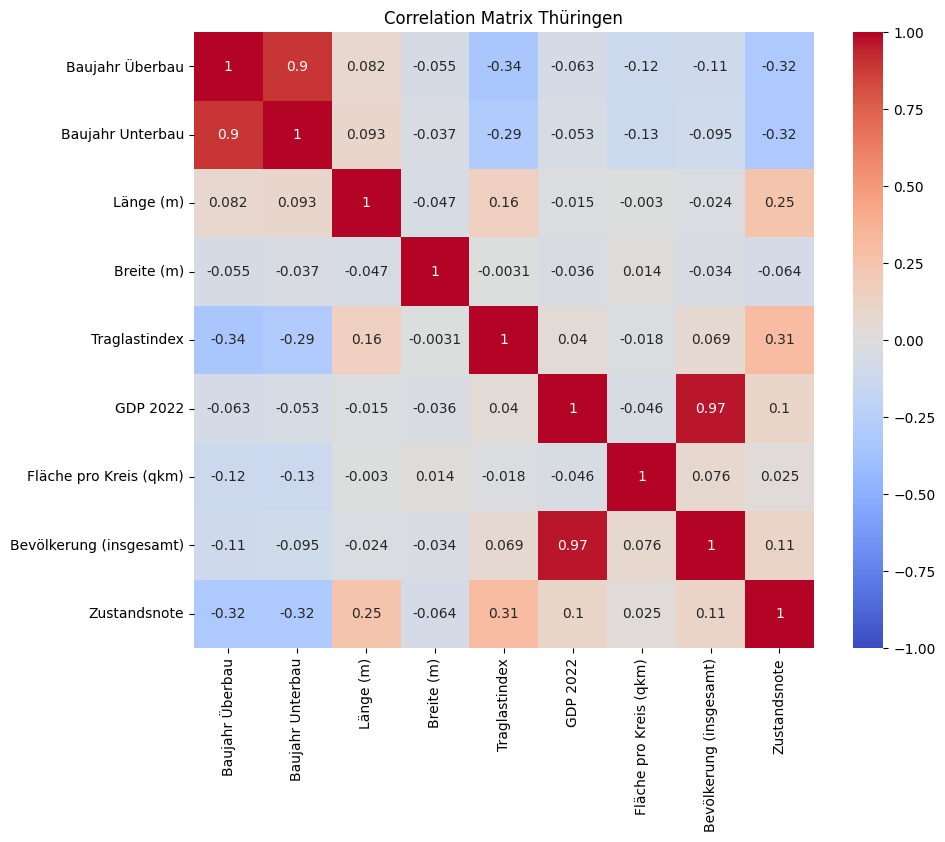

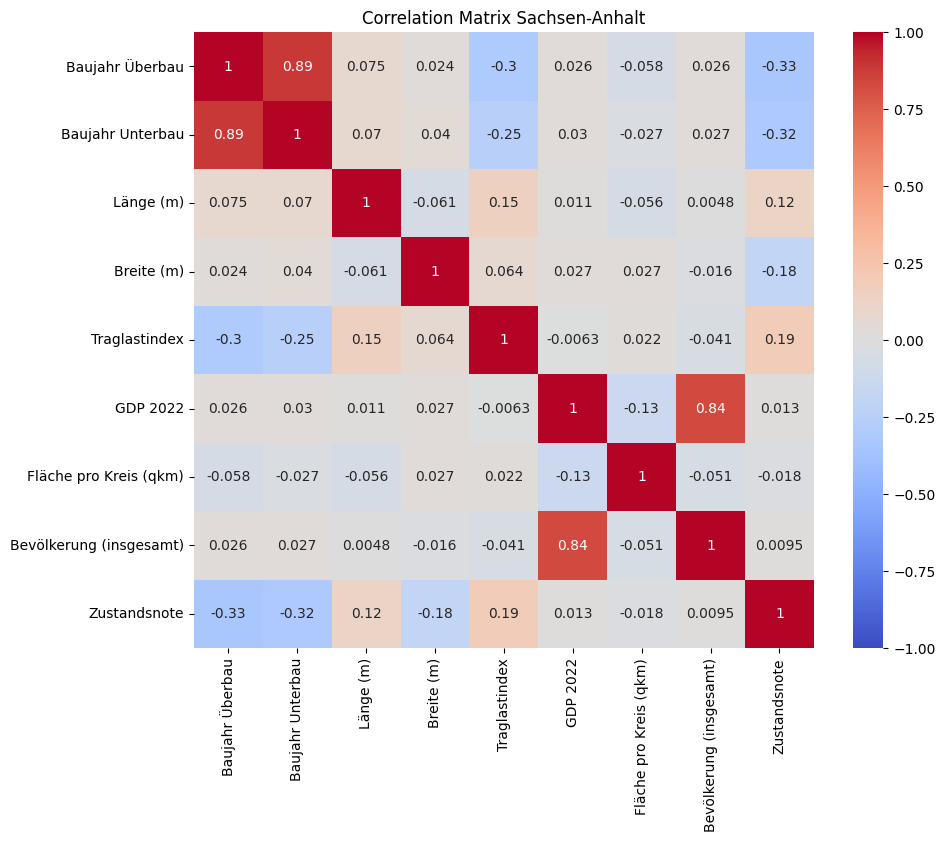

In [9]:
# list of numerical features
num_features = [
    'Baujahr Überbau', 'Baujahr Unterbau', 'Länge (m)', 'Breite (m)',
    'Traglastindex', 'GDP 2022', 'Fläche pro Kreis (qkm)', 'Bevölkerung (insgesamt)', 'Zustandsnote'
]

# Heatmap for Thüringen
corr_th = data_thueringen[num_features].corr(method='pearson')
plt.figure(figsize=(10,8))
sns.heatmap(corr_th, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix Thüringen')
plt.show()

# Heatmap for Sachsen-Anhalt
corr_sa = data_sachsen_anhalt[num_features].corr(method='pearson')
plt.figure(figsize=(10,8))
sns.heatmap(corr_sa, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix Sachsen-Anhalt')
plt.show()

##### Random Forest

In [73]:
# function to perform random forest analysis and plot shapley values
# @param data: DataFrame containing the dataset
# @param target: target variable name as string
# @return: None
def random_forest_shapley_analysis(data, target):
    X = data.drop(columns=[target])
    y = data[target]

    # transform categorical variables using one-hot encoding
    X = pd.get_dummies(X, columns=['Baustoffklasse', 'Baustoff Überbau', 'Zugeordneter Sachverhalt', 'Zugeordneter Sachverhalt vereinfacht', 'Teilbauwerksstadium', 'Teilbauwerksart', 'Kreis'], drop_first=True)

    # split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

    # scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # grid for hyperparameter tuning
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 5, 10],
        'max_features': ['sqrt', 'log2', None]
    }

    # train random forest regressor
    rf = RandomForestRegressor(random_state=4)
    grid_search = GridSearchCV(rf, param_grid, cv=3, n_jobs=-1)
    grid_search.fit(X_train_scaled, y_train)

    # print parameters and evaluate model
    print("Best parameters:", grid_search.best_params_)
    rf_best = grid_search.best_estimator_
    rf_best.fit(X_train_scaled, y_train)
    print(f"Random Forest R^2 Score: {rf_best.score(X_test_scaled, y_test):.4f}")
    y_pred = rf_best.predict(X_test_scaled)
    mse = np.mean((y_test - y_pred) ** 2)
    print(f"Random Forest MSE: {mse:.4f}")

    # calculate shapley values (use TreeExplainer and rf_best)
    explainer = shap.TreeExplainer(rf_best)
    shap_values = explainer.shap_values(X_test_scaled)

    return shap_values, X_test, rf_best, X_train, X

# perform analysis for Thüringen
print("Random Forest Analysis for Thüringen:")
data_thueringen_processed = data_thueringen.drop(columns=['Bundeslandname', 'Bauwerksname', 'Unnamed: 0', 'X', 'Y'])
shap_values, X_test, rf_best, X_train, X = random_forest_shapley_analysis(data_thueringen_processed, 'Zustandsnote')

# perform analysis for Sachsen-Anhalt
print("Random Forest Analysis for Sachsen-Anhalt:")
data_sachsen_anhalt_processed = data_sachsen_anhalt.drop(columns=['Bundeslandname', 'Bauwerksname', 'Unnamed: 0', 'X', 'Y'])
shap_values_s, X_test_s, rf_best_s, X_train_s, X_s = random_forest_shapley_analysis(data_sachsen_anhalt_processed, 'Zustandsnote')
    

Random Forest Analysis for Thüringen:
Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 200}
Random Forest R^2 Score: 0.4675
Random Forest MSE: 0.0919
Random Forest Analysis for Sachsen-Anhalt:
Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 200}
Random Forest R^2 Score: 0.4245
Random Forest MSE: 0.0773


Shapley Values and Feature Importance Plots for Thüringen:


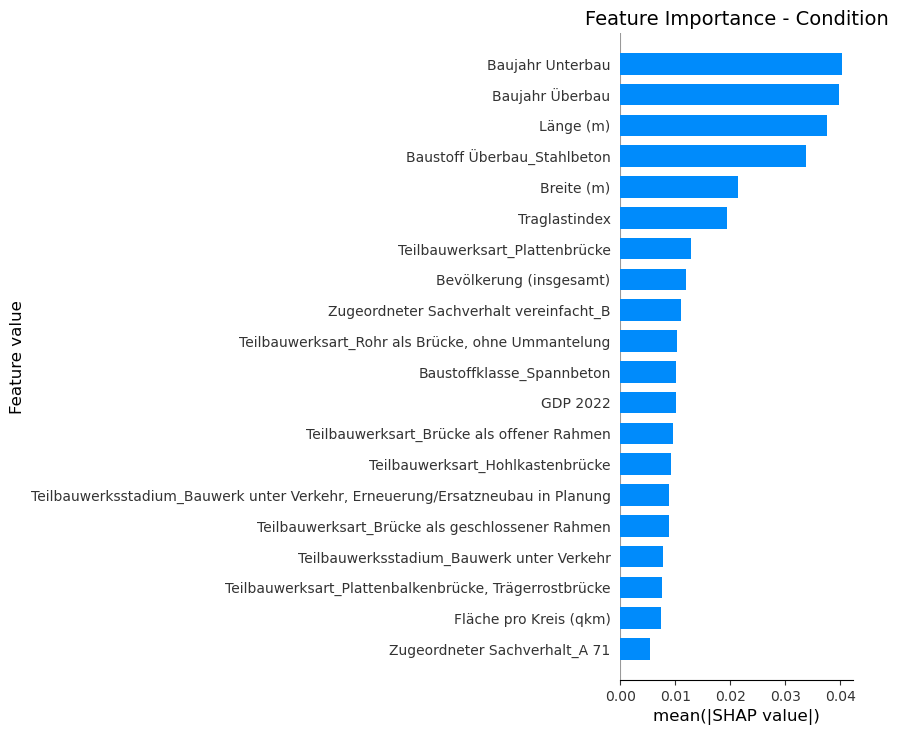

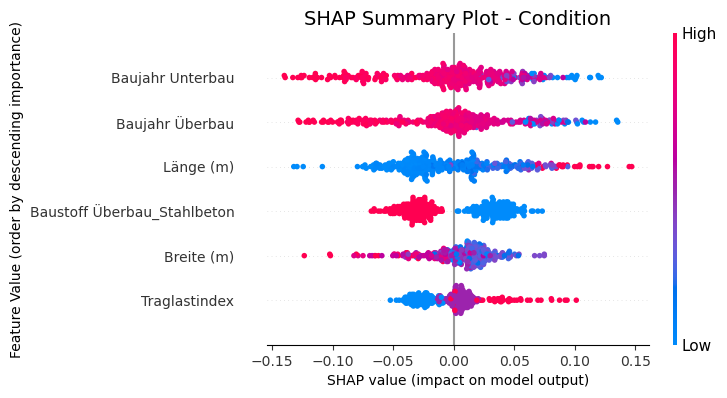

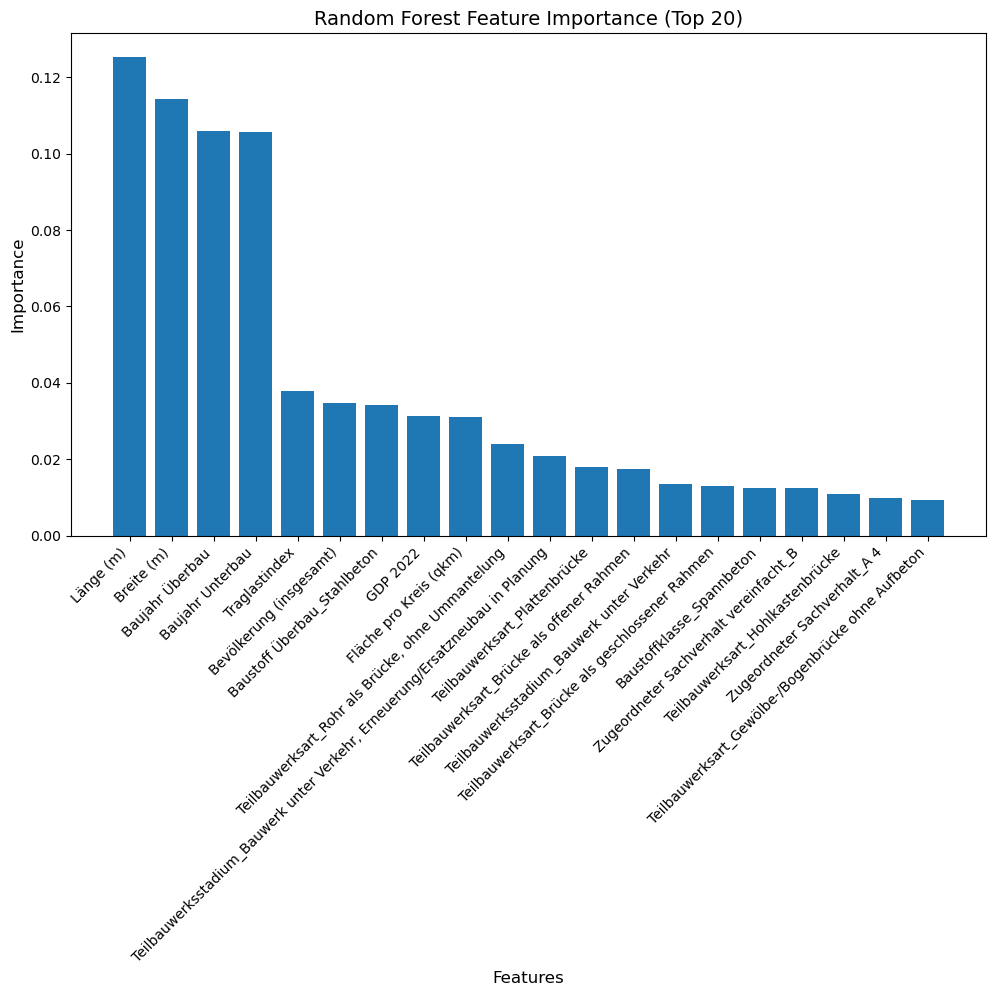


Shapley Values and Feature Importance Plots for Sachsen-Anhalt:


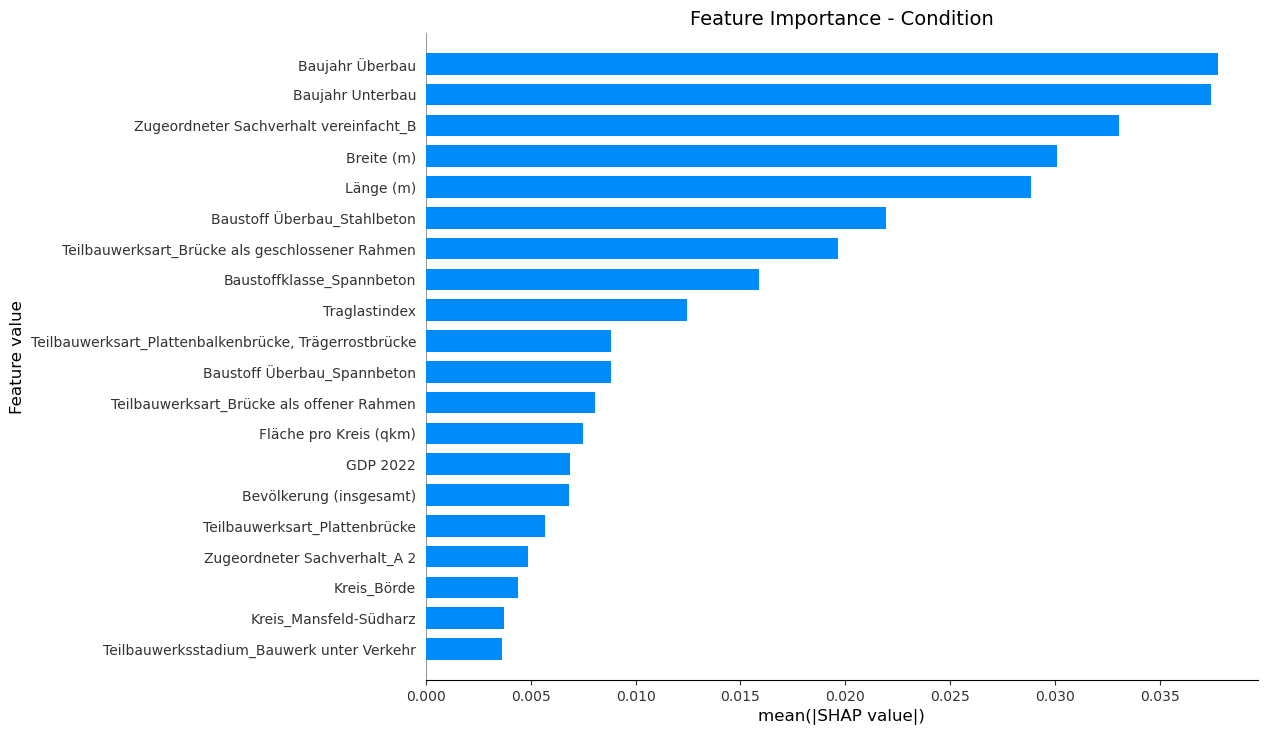

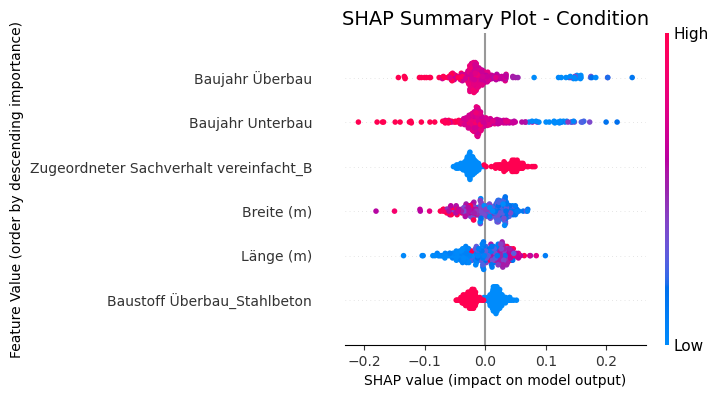

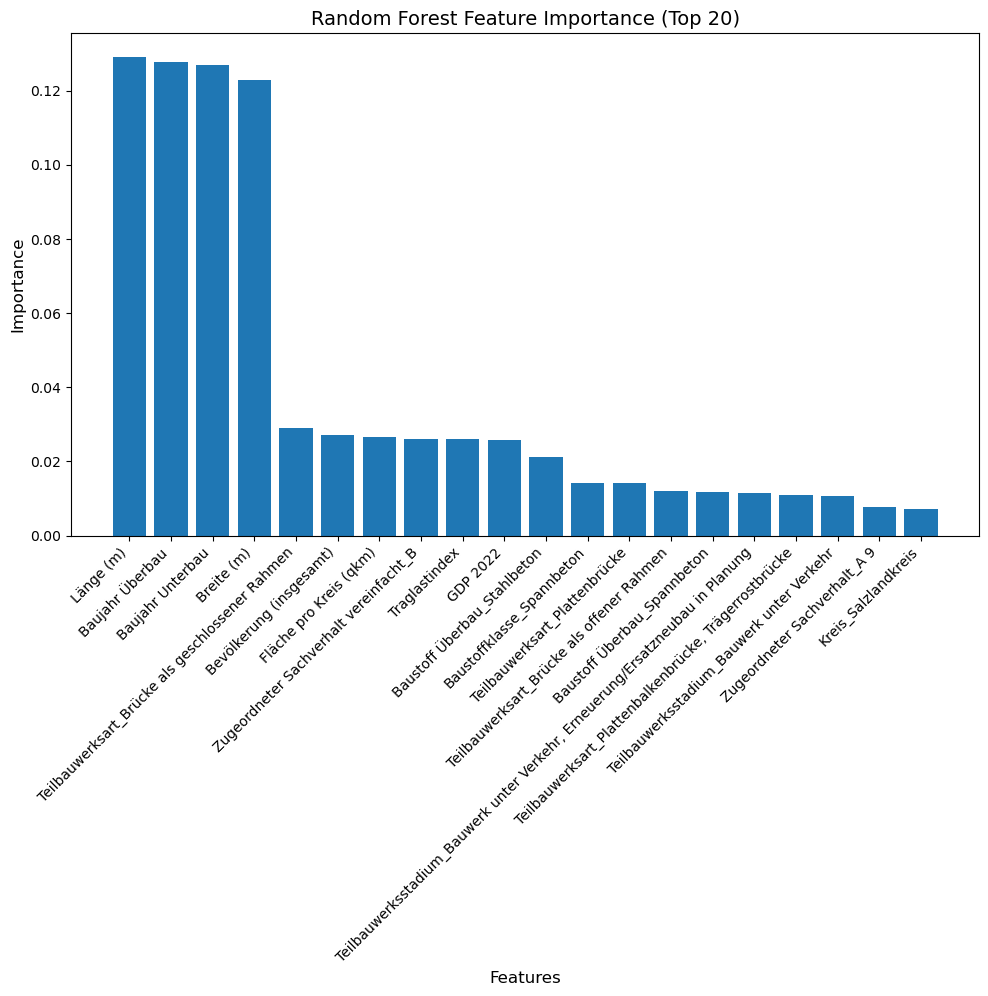

In [84]:

def plot_importance(rf_best, X_train, X):
    # plot feature importance (not based on shapley values)
    # After fitting your random forest (e.g., rf_best.fit(...))
    importances = rf_best.feature_importances_
    feature_names = X_train.columns if isinstance(X_train, pd.DataFrame) else X.columns  # adjust if needed

    # Sort features by importance
    indices = np.argsort(importances)[::-1][:20]  # Only top 20
    plt.figure(figsize=(10, 10))
    plt.title("Random Forest Feature Importance (Top 20)", fontsize=14)
    plt.bar(range(len(indices)), importances[indices], align="center")
    # rotate x-axis labels for better readability (45 degrees)
    plt.xticks(range(len(indices)), [feature_names[i] for i in indices], rotation=45, ha='right', fontsize=10)
    plt.yticks(fontsize=10)
    plt.xlabel("Features", fontsize=12)
    plt.ylabel("Importance", fontsize=12)
    plt.tight_layout()
    plt.show()

    return 

def plot_shapley_values(shap_values, X_test, S):

    # plot shapley values - bar plot
    shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
    # get the current figure and axes objects
    fig, ax = plt.gcf(), plt.gca()

    # modifying main plot parameters
    ax.tick_params(labelsize=10)
    ax.set_xlabel("mean(|SHAP value|)", fontsize=12)
    ax.set_title('Feature Importance - Condition', fontsize=14)

    # get colorbar
    cb_ax = fig.axes[0] 

    # modifying color bar parameters
    cb_ax.tick_params(labelsize=10)
    cb_ax.set_ylabel("Feature value", fontsize=12)

    # make plot wider
    if S: 
        fig.set_size_inches(25, 7)
    else: 
        fig.set_size_inches(150, 7)
    plt.show()

    # plot shapley values - summary plot
    shap.summary_plot(shap_values, X_test, max_display=6, show=False)
    # get the current figure and axes objects
    fig, ax = plt.gcf(), plt.gca()

    # modifying main plot parameters
    ax.tick_params(labelsize=10)
    ax.set_xlabel("SHAP value (impact on model output)", fontsize=10)
    ax.set_title('SHAP Summary Plot - Condition', fontsize=14)

    # get colorbar
    cb_ax = fig.axes[0]

    # modifying color bar parameters
    for ax in fig.axes:
        if hasattr(ax, 'get_ylabel') and ax.get_ylabel() == 'Feature value':
            ax.set_ylabel('')  # Remove label
    cb_ax.tick_params(labelsize=10)
    cb_ax.set_ylabel("Feature Value (order by descending importance)", fontsize=10)

    plt.show()
    return

print("Shapley Values and Feature Importance Plots for Thüringen:")
plot_shapley_values(shap_values, X_test, False)
plot_importance(rf_best, X_train, X)

print("\nShapley Values and Feature Importance Plots for Sachsen-Anhalt:")
plot_shapley_values(shap_values_s, X_test_s, True)
plot_importance(rf_best_s, X_train_s, X_s)